<!--BOOK_INFORMATION-->
<img style="float: right; width: 100px" src="https://raw.github.com/pyomeca/design/master/logo/logo_cropped.svg?sanitize=true">

<font size="+2">Pyosim in the cloud</font>

<font size="+1">with [pyomeca](https://github.com/pyomeca/pyom</font>a)

Romain Martinez (martinez.staps@gmail.com | [GitHub](https://github.com/romainmartinez))


<!--NAVIGATION-->
< [EMG](03.02-emg.ipynb) | [Contents](Index.ipynb) | [Joint reactions](03.04-joint-reactions.ipynb) >

# Muscle activations & muscles forces

In [1]:
from pathlib import Path

import numpy as np
import pandas as pd
import altair as alt
from pyosim import Conf
from pyomeca import Analogs3d
import spm1d
import matplotlib.pyplot as plt

from src.util import (
    condition_counter,
    random_balanced_design,
    get_spm_cluster,
    ridge_plot,
)

In [2]:
%load_ext autoreload
%autoreload 2
%load_ext lab_black
alt.data_transformers.enable("json")
# to make this notebook's output stable across runs
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

In [3]:
project_path = Path("/media/romain/E/Projet_ExpertsNovices/opensim")
conf = Conf(project_path=project_path)
conf.check_confs()

Project loaded
Configuration file loaded


## Reading files

In [4]:
def parse_conditions(d):
    return (
        d.assign(
            mass=lambda x: x["filename"]
            .str.contains("r08")
            .replace({True: 8, False: 12})
        )
        .merge(
            pd.read_csv(project_path / "_conf.csv")[["participant", "group"]].rename(
                columns={"group": "men"}
            ),
            on="participant",
            how="left",
        )
        .assign(height=1)
    )

In [5]:
suffix = "_StaticOptimization_activation"
# suffix = "_StaticOptimization_force"

act = (
    pd.concat(
        [
            Analogs3d.from_sto(ifile)
            .time_normalization()
            .to_dataframe()
            .assign(
                participant=ifile.parts[-3],
                filename=lambda x: ifile.stem + ifile.parts[-3] + f"{i}",
            )
            .reset_index()
            for i, ifile in enumerate(
                conf.project_path.glob(f"*/3_static_optimization/*{suffix}*")
            )
        ]
    ).pipe(parse_conditions)
    .assign(index=lambda x: x["index"] / 100)
)

act.head()

,index,LVS,TRP1,TRP2,TRP3,TRP4,RMN,RMJ1,RMJ2,SRA1,...,AC2,AC3,GH1,GH2,GH3,participant,filename,mass,men,height
0,0.00,0.031669,0.278762,0.169834,0.010002,0.01,0.010003,0.010002,0.010002,0.010001,...,-0.594642,-0.171937,0.004562,0.000730,0.005012,antc,wu_expertsnovicesG_1_r08_4_StaticOptimization_...,8,0,1
1,0.01,0.031491,0.305627,0.186378,0.010002,0.01,0.010002,0.010001,0.010001,0.010001,...,-0.764102,-0.222692,0.004980,0.002179,0.003247,antc,wu_expertsnovicesG_1_r08_4_StaticOptimization_...,8,0,1
2,0.02,0.036226,0.341190,0.128134,0.010002,0.01,0.010002,0.010001,0.010001,0.010001,...,-0.872092,-0.227086,0.004825,0.002635,0.001819,antc,wu_expertsnovicesG_1_r08_4_StaticOptimization_...,8,0,1
3,0.03,0.044278,0.358148,0.055405,0.010001,0.01,0.010002,0.010001,0.010001,0.010001,...,-0.902973,-0.197947,0.004312,0.002459,0.001430,antc,wu_expertsnovicesG_1_r08_4_StaticOptimization_...,8,0,1
4,0.04,0.044646,0.335845,0.032404,0.010002,0.01,0.010003,0.010001,0.010001,0.010001,...,-0.755765,-0.145758,0.003865,0.001300,0.002854,antc,wu_expertsnovicesG_1_r08_4_StaticOptimization_...,8,0,1


## Clean data

### Balance dataset

By randomly taking the minimum number of trials for each condition

In [6]:
act.drop_duplicates(["filename"]).groupby(["men", "mass"]).size()

men  mass
0    8        93
     12      114
1    8        54
     12       41
dtype: int64

In [7]:
balanced_trials = random_balanced_design(
    act, ["men", "mass"], random_state=RANDOM_SEED
)["filename"].to_list()

In [8]:
act = act.query("filename == @balanced_trials")
act.drop_duplicates(["filename"]).groupby(["men", "mass"]).size()

men  mass
0    8       41
     12      41
1    8       41
     12      41
dtype: int64

### Drop unwanted variables

In [9]:
id_vars = ["filename", "participant", "men", "height", "mass", "index"]
act_melt = act.melt(id_vars=id_vars)
act_melt.head()

,filename,participant,men,height,mass,index,variable,value
0,wu_expertsnovicesG_1_r08_4_StaticOptimization_...,antc,0,1,8,0.00,LVS,0.031669
1,wu_expertsnovicesG_1_r08_4_StaticOptimization_...,antc,0,1,8,0.01,LVS,0.031491
2,wu_expertsnovicesG_1_r08_4_StaticOptimization_...,antc,0,1,8,0.02,LVS,0.036226
3,wu_expertsnovicesG_1_r08_4_StaticOptimization_...,antc,0,1,8,0.03,LVS,0.044278
4,wu_expertsnovicesG_1_r08_4_StaticOptimization_...,antc,0,1,8,0.04,LVS,0.044646


In [10]:
blacklist = ["AC1", "AC2", "AC3", "SC1", "SC2", "SC3", "GH1", "GH2", "GH3"]
blacklist = blacklist + [
    "box_Rx",
    "box_Ry",
    "box_Rz",
    "box_Tx",
    "box_Ty",
    "box_Tz",
    "thorax_Tx",
    "thorax_Ty",
    "thorax_Tz",
    "thorax_Rx",
    "thorax_Ry",
    "thorax_Rz",
    "elbow_Rz",
    "elbow_Ry",
    "hand_Rz",
    "hand_Rx",
    "hand_s2h_Fx",
    "hand_s2h_Fy",
    "hand_s2h_Fz",
    "hand_s2h_Tx",
    "hand_s2h_Ty",
    "hand_s2h_Tz",
    "hand_s2h_px",
    "hand_s2h_py",
    "hand_s2h_pz",
]

act_melt = act_melt.query("variable != @blacklist")

In [11]:
# gh_muscles = [
#     "DELT1",
#     "DELT2",
#     "DELT3",
#     "INFSP",
#     "LAT",
#     "PECM1",
#     "PECM2",
#     "PECM3",
#     "SUBSC",
#     "SUPSP",
#     "TMAJ",
#     "TMIN",
#     "CORB",
# ]
# act_melt = act_melt.query("variable == @gh_muscles")

## Description

In [12]:
print(
    f"value > 0.999 = {act_melt.query('value > 0.999').shape[0] / act_melt.shape[0] * 100:.2f}%"
)

value > 0.999 = 2.20%


In [13]:
x = act_melt.groupby(["variable", "index"])["value"].mean().reset_index()
x.head()

,variable,index,value
0,CORB,0.00,0.028565
1,CORB,0.01,0.026308
2,CORB,0.02,0.027488
3,CORB,0.03,0.032020
4,CORB,0.04,0.038279


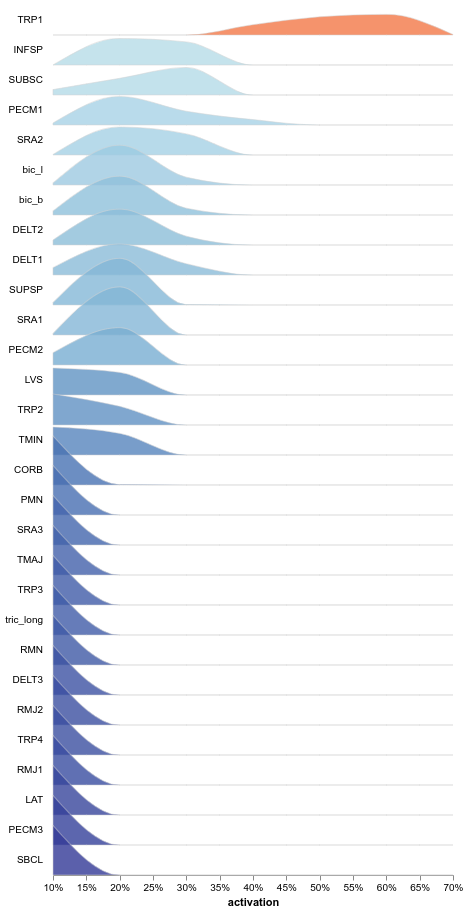

In [14]:
ridge_plot(
    act_melt.groupby(["variable", "index"])["value"].mean().reset_index(),
    value="value",
    groupby="variable",
    sort=act_melt.groupby(["variable"])["value"]
    .mean()
    .sort_values(ascending=False)
    .index.to_list(),
)

## $\sum$activation

In [15]:
sum_act = act_melt.groupby(id_vars)["value"].sum().reset_index()
sum_act.head()

,filename,participant,men,height,mass,index,value
0,wu_expertsnovicesD_1_r08_1_StaticOptimization_...,erib,1,1,8,0.00,1.296798
1,wu_expertsnovicesD_1_r08_1_StaticOptimization_...,erib,1,1,8,0.01,1.141101
2,wu_expertsnovicesD_1_r08_1_StaticOptimization_...,erib,1,1,8,0.02,1.032823
3,wu_expertsnovicesD_1_r08_1_StaticOptimization_...,erib,1,1,8,0.03,0.971091
4,wu_expertsnovicesD_1_r08_1_StaticOptimization_...,erib,1,1,8,0.04,0.952626


In [16]:
y = (
    sum_act.assign(participant=lambda x: x["participant"].astype("category").cat.codes)
    .set_index(id_vars)
    .unstack()
)
y.head()

value  \
index                                                                                0.00   
filename                                           participant men height mass              
wu_expertsnovicesD_1_r08_1_StaticOptimization_a... 8           1   1      8      1.296798   
wu_expertsnovicesD_1_r08_1_StaticOptimization_a... 9           1   1      8     15.140000   
wu_expertsnovicesD_1_r08_1_StaticOptimization_a... 10          1   1      8      1.296611   
wu_expertsnovicesD_1_r08_1_StaticOptimization_a... 11          0   1      8      1.301416   
wu_expertsnovicesD_1_r08_1_StaticOptimization_a... 13          0   1      8      2.778879   

                                                                                           \
index                                                                                0.01   
filename                                           participant men height mass              
wu_expertsnovicesD_1_r08_1_StaticOptimization_a... 8           1   1      8      1.141101   
wu_expertsnovicesD_1_r08_1_StaticOptimization_a... 9           1   1      8     14.771763   
wu_expertsnovicesD_1_r08_1_StaticOptimization_a... 10          1   1      8      0.897090   
wu_expertsnovicesD_1_r08_1_StaticOptimization_a... 11          0   1      8      1.749649   
wu_expertsnovicesD_1_r08_1_StaticOptimization_a... 13          0   1      8      2.292070   

                                                                                           \
index                                                                                0.02   
filename                                           participant men height mass              
wu_expertsnovicesD_1_r08_1_StaticOptimization_a... 8           1   1      8      1.032823   
wu_expertsnovicesD_1_r08_1_StaticOptimization_a... 9           1   1      8     15.003216   
wu_expertsnovicesD_1_r08_1_StaticOptimization_a... 10          1   1      8      0.657310   
wu_expertsnovicesD_1_r08_1_StaticOptimization_a... 11          0   1      8      2.871707   
wu_expertsnovicesD_1_r08_1_StaticOptimization_a... 13          0   1      8      1.840692   

                                                                                           \
index                                                                                0.03   
filename                                           participant men height mass              
wu_expertsnovicesD_1_r08_1_StaticOptimization_a... 8           1   1      8      0.971091   
wu_expertsnovicesD_1_r08_1_StaticOptimization_a... 9           1   1      8     14.768243   
wu_expertsnovicesD_1_r08_1_StaticOptimization_a... 10          1   1      8      0.629689   
wu_expertsnovicesD_1_r08_1_StaticOptimization_a... 11          0   1      8      3.769581   
wu_expertsnovicesD_1_r08_1_StaticOptimization_a... 13          0   1      8      1.332253   

                                                                                           \
index                                                                                0.04   
filename                                           participant men height mass              
wu_expertsnovicesD_1_r08_1_StaticOptimization_a... 8           1   1      8      0.952626   
wu_expertsnovicesD_1_r08_1_StaticOptimization_a... 9           1   1      8     14.714660   
wu_expertsnovicesD_1_r08_1_StaticOptimization_a... 10          1   1      8      1.115414   
wu_expertsnovicesD_1_r08_1_StaticOptimization_a... 11          0   1      8      4.237464   
wu_expertsnovicesD_1_r08_1_StaticOptimization_a... 13          0   1      8      1.155589   

                                                                                           \
index                                                                                0.05   
filename                                           participant men height mass              
wu_expertsnovicesD_1_r08_1_StaticOptimization_a... 8           1   1      8     

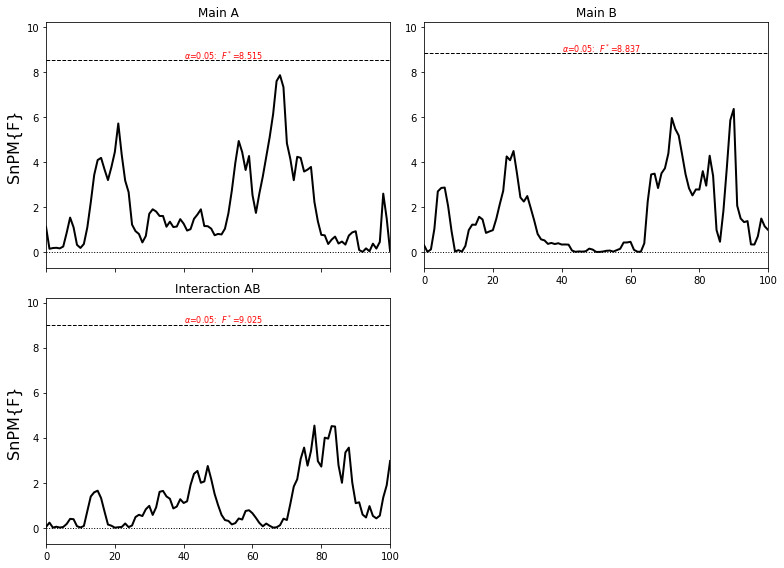

In [17]:
α = 0.05
n_iter = 1000
spm = spm1d.stats.nonparam.anova2(
    y.to_numpy(), A=y.index.get_level_values("men"), B=y.index.get_level_values("mass")
)
spmi = spm.inference(alpha=α, iterations=n_iter)

plt.figure(figsize=(11, 8))
spmi.plot()
plt.tight_layout()

In [20]:
clusters = get_spm_cluster(
    spmi,
    labels={
        "Main A": "main sex",
        "Main B": "main mass",
        "Interaction AB": "interaction sex-mass",
    },
    mult=1 / y.shape[1],
)

ValueError: No objects to concatenate

In [21]:
c = (
    alt.Chart(clusters)
    .mark_rect(opacity=0.3, color="grey")
    .encode(alt.X("start"), alt.X2("end"))
)

NameError: name 'clusters' is not defined

In [22]:
base = alt.Chart(sum_act.query("participant != @blacklist")).encode(
    alt.X(
        "index", title="normalized trial", axis=alt.Axis(format="%", labelFlush=False)
    )
)
mu = base.mark_line().encode(alt.Y("mean(value)", title="Σ activation"))
sigma = base.mark_errorband(extent="stdev").encode(alt.Y("value", title=None))
men_scale = alt.Scale(scheme="set1")

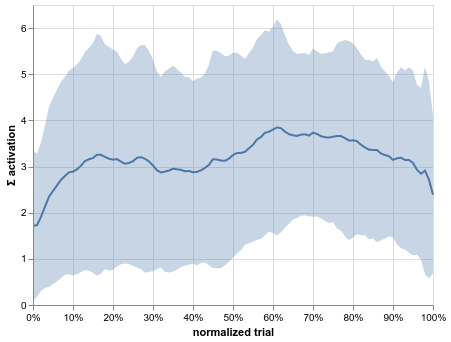

In [23]:
(mu + sigma)  # + c.encode(alt.Color("effect"))

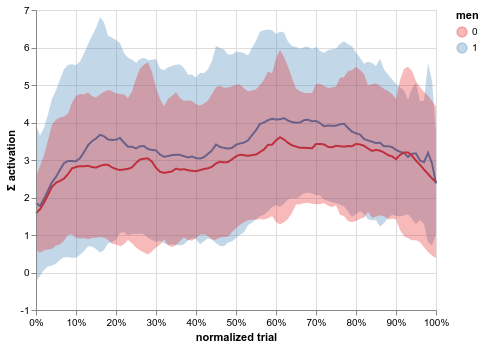

In [24]:
# c.transform_filter('datum.effect == "main sex"') +
(mu + sigma).encode(alt.Color("men:N", scale=men_scale))

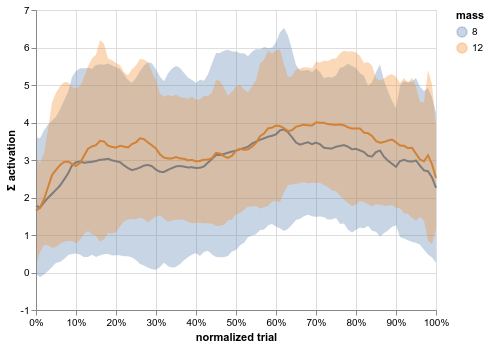

In [25]:
# c.transform_filter('datum.effect == "main mass"') +
(mu + sigma).encode(alt.Color("mass:N"))

In [ ]:
(
    c.transform_filter('datum.effect == "main sex"')
    + (mu + sigma).encode(alt.Color("men:N", scale=men_scale))
    | c.transform_filter('datum.effect == "main mass"')
    + (mu + sigma).encode(alt.Color("mass:N"))
).resolve_scale(x="shared", y="shared")

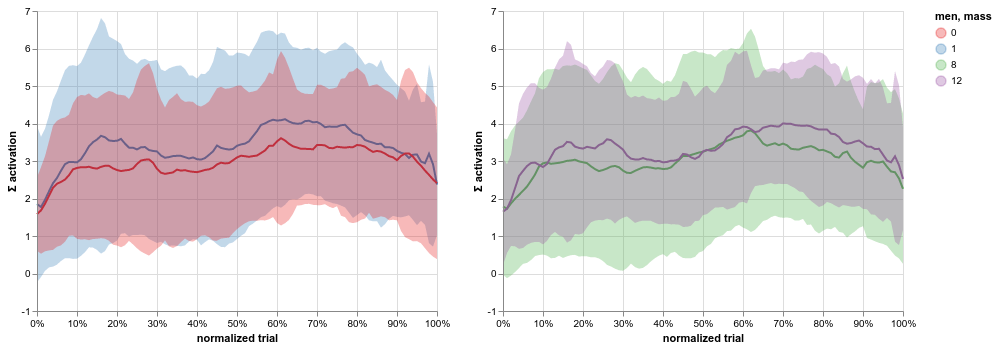

In [26]:
(
    (mu + sigma).encode(alt.Color("men:N", scale=men_scale))
    | (mu + sigma).encode(alt.Color("mass:N"))
).resolve_scale(x="shared", y="shared")

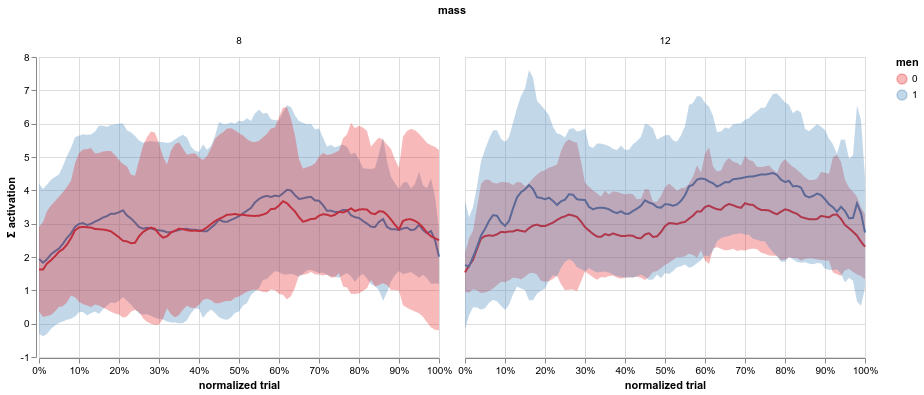

In [27]:
(mu + sigma).encode(alt.Color("men:N", scale=men_scale)).facet(column="mass")

## ECDF

### ECDF on activations

In [28]:
act_melt["ecdf"] = act_melt.groupby("filename")["value"].transform(
    lambda x: x.rank(method="first") / x.shape[0]
)

In [29]:
target_col_shape = 100

y = (
    act_melt.drop(["index", "variable"], axis=1)
    .assign(participant=lambda x: x["participant"].astype("category").cat.codes)
    .set_index([i if i != "index" else "ecdf" for i in id_vars])
    .unstack()
)
y = y.iloc[:, 0 :: int(y.shape[1] / target_col_shape)]
y.head()

value  \
ecdf                                                                           0.000341   
filename                                           participant men height mass            
wu_expertsnovicesD_1_r08_1_StaticOptimization_a... 8           1   1      8        0.01   
wu_expertsnovicesD_1_r08_1_StaticOptimization_a... 9           1   1      8        0.01   
wu_expertsnovicesD_1_r08_1_StaticOptimization_a... 10          1   1      8        0.01   
wu_expertsnovicesD_1_r08_1_StaticOptimization_a... 11          0   1      8        0.01   
wu_expertsnovicesD_1_r08_1_StaticOptimization_a... 13          0   1      8        0.01   

                                                                                         \
ecdf                                                                           0.010242   
filename                                           participant men height mass            
wu_expertsnovicesD_1_r08_1_StaticOptimization_a... 8           1   1      8        0.01   
wu_expertsnovicesD_1_r08_1_StaticOptimization_a... 9           1   1      8        0.01   
wu_expertsnovicesD_1_r08_1_StaticOptimization_a... 10          1   1      8        0.01   
wu_expertsnovicesD_1_r08_1_StaticOptimization_a... 11          0   1      8        0.01   
wu_expertsnovicesD_1_r08_1_StaticOptimization_a... 13          0   1      8        0.01   

                                                                                          \
ecdf                                                                            0.020143   
filename                                           participant men height mass             
wu_expertsnovicesD_1_r08_1_StaticOptimization_a... 8           1   1      8     0.010000   
wu_expertsnovicesD_1_r08_1_StaticOptimization_a... 9           1   1      8     0.010000   
wu_expertsnovicesD_1_r08_1_StaticOptimization_a... 10          1   1      8     0.010000   
wu_expertsnovicesD_1_r08_1_StaticOptimization_a... 11          0   1      8     0.010001   
wu_expertsnovicesD_1_r08_1_StaticOptimization_a... 13          0   1      8     0.010000   

                                                                                          \
ecdf                                                                            0.030044   
filename                                           participant men height mass             
wu_expertsnovicesD_1_r08_1_StaticOptimization_a... 8           1   1      8     0.010000   
wu_expertsnovicesD_1_r08_1_StaticOptimization_a... 9           1   1      8     0.010000   
wu_expertsnovicesD_1_r08_1_StaticOptimization_a... 10          1   1      8     0.010000   
wu_expertsnovicesD_1_r08_1_StaticOptimization_a... 11          0   1      8     0.010002   
wu_expertsnovicesD_1_r08_1_StaticOptimization_a... 13          0   1      8     0.010000   

                                                                                          \
ecdf                                                                            0.039945   
filename                                           participant men height mass             
wu_expertsnovicesD_1_r08_1_StaticOptimization_a... 8           1   1      8     0.010000   
wu_expertsnovicesD_1_r08_1_StaticOptimization_a... 9           1   1      8     0.010000   
wu_expertsnovicesD_1_r08_1_StaticOptimization_a... 10          1   1      8     0.010000   
wu_expertsnovicesD_1_r08_1_StaticOptimization_a... 11          0   1      8     0.010002   
wu_expertsnovicesD_1_r08_1_StaticOptimization_a... 13          0   1      8     0.010000   

                                                                                          \
ecdf                                                                            0.049846   
filename                                           participant men height mass             
wu_expertsnovicesD_1_r08_1_StaticOptimization_a... 8           1   1      8     0.010000   
wu_expertsnovicesD_1_r08_1_StaticOptimization

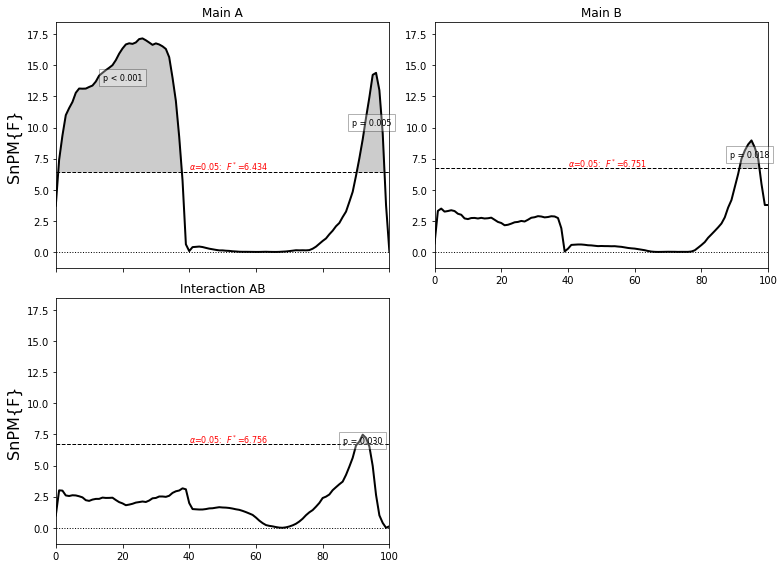

In [30]:
α = 0.05
n_iter = 1000
spm = spm1d.stats.nonparam.anova2(
    y.to_numpy(), A=y.index.get_level_values("men"), B=y.index.get_level_values("mass")
)
spmi = spm.inference(alpha=α, iterations=n_iter)

plt.figure(figsize=(11, 8))
spmi.plot()
plt.tight_layout()

In [31]:
clusters = get_spm_cluster(
    spmi,
    labels={
        "Main A": "main sex",
        "Main B": "main mass",
        "Interaction AB": "interaction sex-mass",
    },
    mult=1 / y.shape[1],
)
clusters

,effect,p,start,end
0,main sex,0,0.00732,0.374252
1,main sex,0.00533333,0.893252,0.97559
2,main mass,0.018,0.904959,0.964061
3,interaction sex-mass,0.0303333,0.895469,0.927511


In [32]:
c = (
    alt.Chart(clusters)
    .mark_rect(opacity=0.3, color="grey")
    .encode(alt.X("start"), alt.X2("end"))
)

In [33]:
base = alt.Chart(y.stack().reset_index()).encode(
    alt.X("ecdf", axis=alt.Axis(format="%"), title="ecdf")
)
mu = base.mark_line().encode(alt.Y("mean(value)", title="activation"))
sigma = base.mark_errorband(extent="stdev").encode(alt.Y("value", title=None))

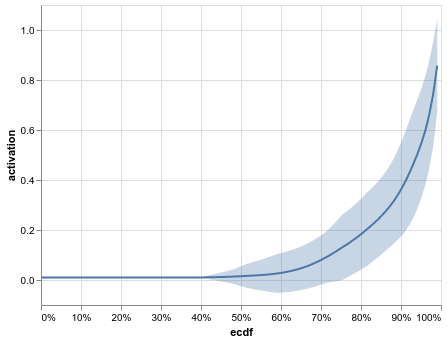

In [34]:
(mu + sigma)  # + c.encode(alt.Color("effect"))

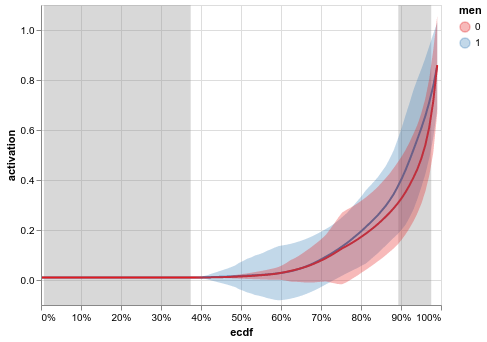

In [35]:
c.transform_filter('datum.effect == "main sex"') + (mu + sigma).encode(
    alt.Color("men:N", scale=men_scale)
)

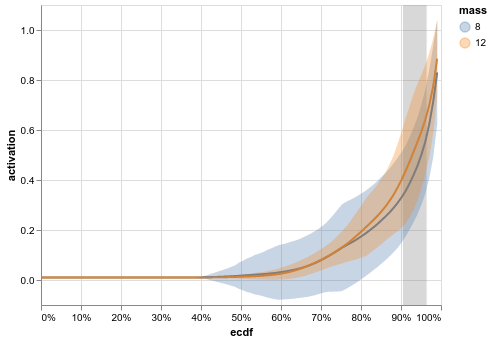

In [36]:
c.transform_filter('datum.effect == "main mass"') + (mu + sigma).encode(
    alt.Color("mass:N")
)

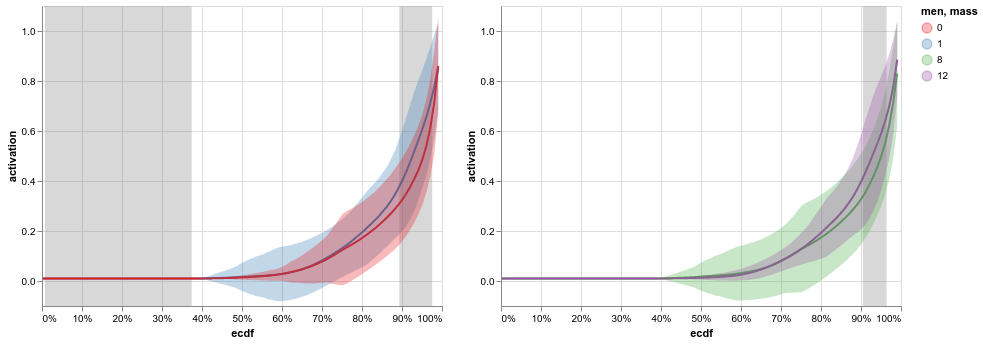

In [37]:
(
    c.transform_filter('datum.effect == "main sex"')
    + (mu + sigma).encode(alt.Color("men:N", scale=men_scale))
    | c.transform_filter('datum.effect == "main mass"')
    + (mu + sigma).encode(alt.Color("mass:N"))
).resolve_scale(x="shared", y="shared")

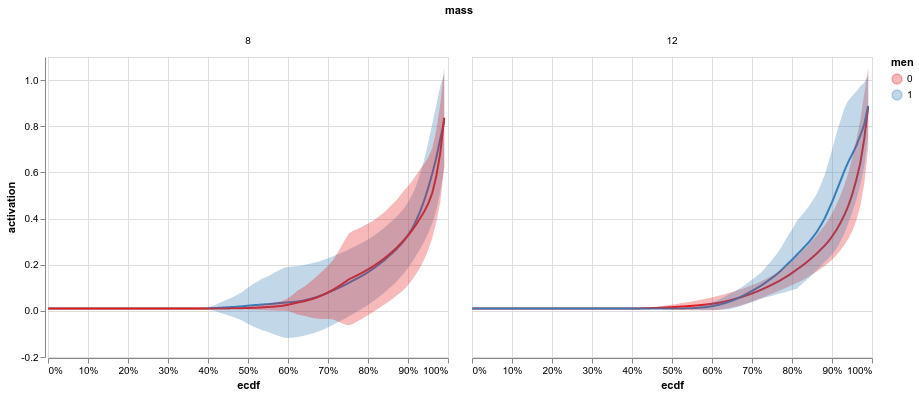

In [38]:
(mu + sigma).encode(alt.Color("men:N", scale=men_scale)).facet(column="mass")

## $\sum\sum\text{activations}$

In [37]:
sum_sum_act = (
    sum_act.groupby([i for i in id_vars if i != "index"])["value"].sum().reset_index()
)
sum_sum_act.head()

,filename,participant,men,height,mass,value
0,wu_expertsnovicesD_1_r08_1_StaticOptimization_...,blam,1,1,8,194195.882811
1,wu_expertsnovicesD_1_r08_1_StaticOptimization_...,eric,1,1,8,568663.551900
2,wu_expertsnovicesD_1_r08_1_StaticOptimization_...,fras,1,1,8,124870.876360
3,wu_expertsnovicesD_1_r08_1_StaticOptimization_...,gaud,0,1,8,115291.212108
4,wu_expertsnovicesD_1_r08_1_StaticOptimization_...,jead,1,1,8,125494.613333


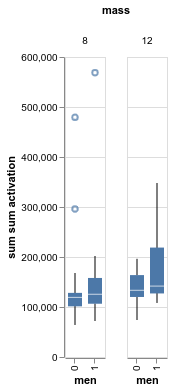

In [38]:
alt.Chart().mark_boxplot().encode(
    alt.X("men:N"), alt.Y("value", title="sum sum activation")
).facet(data=sum_sum_act, column=alt.Column("mass"))

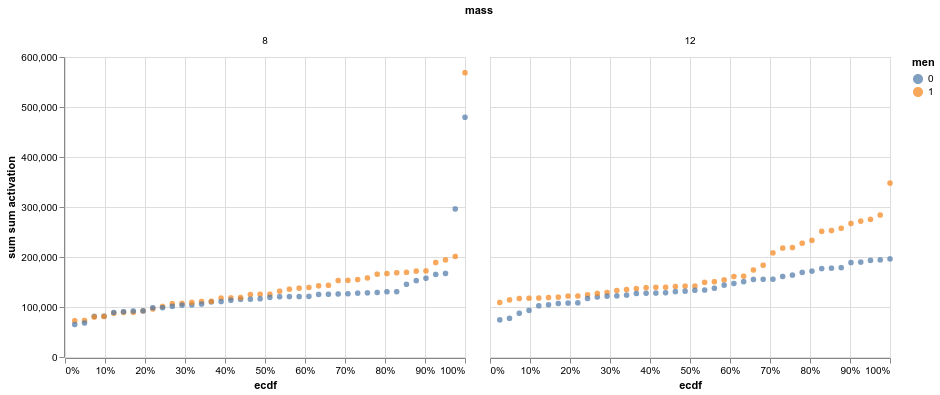

In [39]:
alt.Chart(
    sum_sum_act.assign(
        ecdf=lambda x: x.groupby(["men", "mass"])["value"].transform(
            lambda x: x.rank(method="first") / x.shape[0]
        )
    )
).mark_circle().encode(
    alt.X("ecdf", axis=alt.Axis(format="%")),
    alt.Y("value", title="sum sum activation"),
    alt.Color("men:N"),
    alt.Column("mass"),
)

<!--NAVIGATION-->
< [EMG](03.02-emg.ipynb) | [Contents](Index.ipynb) | [Joint reactions](03.04-joint-reactions.ipynb) >